# Forecasting with an RNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-26 10:17:11.738496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

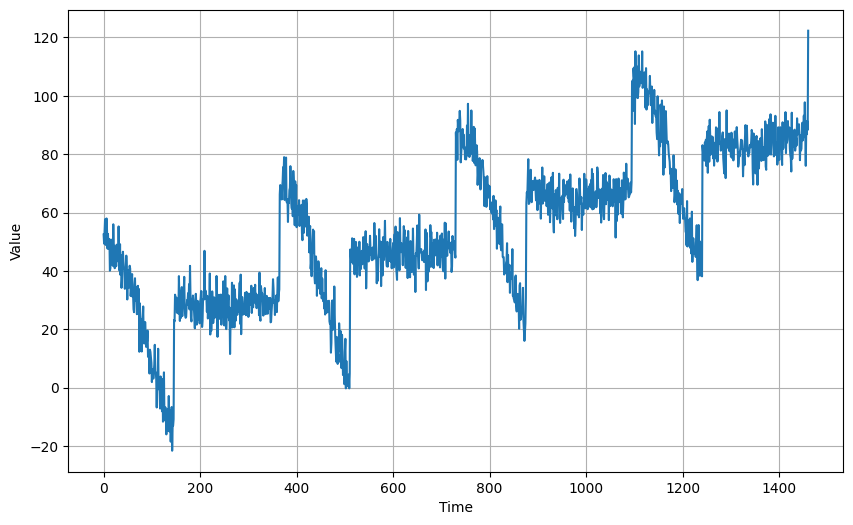

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-26 10:17:15.601190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
8/8 [==============================] - 2s 75ms/step - loss: 246.3212 - mae: 246.8212 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 207.5849 - mae: 208.0848 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 142.7339 - mae: 143.2339 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 63.8937 - mae: 64.3937 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 21ms/step - loss: 24.1667 - mae: 24.6633 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 22.8044 - mae: 23.3010 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 32ms/step - loss: 16.8850 - mae: 17.3785 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 41ms/step - loss: 13.7498 - mae: 14.2346 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 12.7197 - mae: 13.2058 - l

(1e-07, 0.0001, 0.0, 30.0)

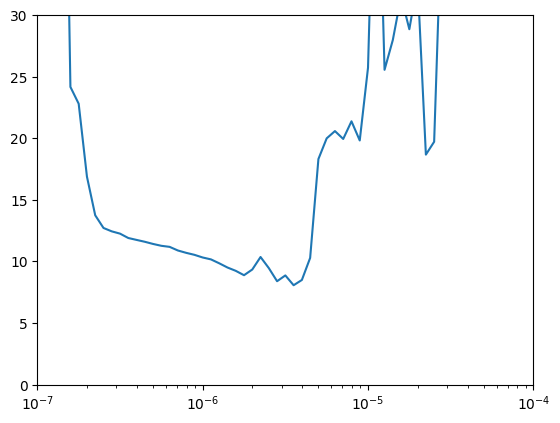

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience = 50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs = 20,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
      7/Unknown - 2s 33ms/step - loss: 27627.9238 - mae: 27628.4238

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 5s 501ms/step - loss: 27547.8945 - mae: 27548.3965 - val_loss: 44186.5000 - val_mae: 44187.0039
Epoch 2/20
7/8 [=========================>....] - ETA: 0s - loss: 39831.9492 - mae: 39832.4492

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 4s 518ms/step - loss: 39135.3594 - mae: 39135.8633 - val_loss: 26804.0664 - val_mae: 26804.5664
Epoch 3/20
7/8 [=========================>....] - ETA: 0s - loss: 35999.5508 - mae: 36000.0508

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 4s 498ms/step - loss: 36473.4961 - mae: 36473.9961 - val_loss: 16358.3037 - val_mae: 16358.8037
Epoch 4/20
8/8 [==============================] - 0s 37ms/step - loss: 35784.9414 - mae: 35785.4375 - val_loss: 63532.6680 - val_mae: 63533.1680
Epoch 5/20
8/8 [==============================] - 0s 38ms/step - loss: 41473.7031 - mae: 41474.2031 - val_loss: 22502.7109 - val_mae: 22503.2090
Epoch 6/20
7/8 [=========================>....] - ETA: 0s - loss: 33256.2266 - mae: 33256.7266

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 3s 424ms/step - loss: 32762.2109 - mae: 32762.7090 - val_loss: 573.1085 - val_mae: 573.6085
Epoch 7/20
8/8 [==============================] - 0s 38ms/step - loss: 35044.4844 - mae: 35044.9805 - val_loss: 74869.6797 - val_mae: 74870.1797
Epoch 8/20
8/8 [==============================] - 0s 45ms/step - loss: 43234.2188 - mae: 43234.7188 - val_loss: 14720.3281 - val_mae: 14720.8281
Epoch 9/20
8/8 [==============================] - 0s 40ms/step - loss: 34244.0117 - mae: 34244.5117 - val_loss: 7002.9043 - val_mae: 7003.4043
Epoch 10/20
8/8 [==============================] - 0s 39ms/step - loss: 32203.0957 - mae: 32203.5957 - val_loss: 18254.9922 - val_mae: 18255.4941
Epoch 11/20
8/8 [==============================] - 0s 50ms/step - loss: 20166.2109 - mae: 20166.7109 - val_loss: 39741.6953 - val_mae: 39742.1953
Epoch 12/20
8/8 [==============================] - 0s 35ms/step - loss: 54878.5273 - mae: 54879.0273 - val_loss: 129027.3672 - val_mae: 129027.8

In [8]:
empirical_model = keras.models.load_model("my_checkpoint")

In [9]:
empirical_rnn_forecast = model_forecast(
    empirical_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


## Simple Mechanized RNN Forecasting

In [10]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

mechanized_model = MechanizedSequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

gaussian_history = mechanized_model.fit(train_set, epochs = 20, callbacks=[lr_schedule])

Epoch 1/20
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 384ms/step - loss: 138.1053 - mae: 138.6053In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      2/Unknown - 1s 160ms/step - loss: 135.7846 - mae: 136.2831In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      3/Unknown - 1s 163ms/step - loss: 135.1805 - mae: 135.6795In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 1s 175ms/step - loss: 133.1442 - mae: 133.6434In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 1s 196ms/step - loss: 130.5006 - mae: 131.0000In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 1s 187ms/step - loss: 127.4880 - mae: 127.9875In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      7/Unknown - 1s 180ms/step - loss: 124.5032 - mae: 125.0028In

## Choose Threshold mechanism and fit the model

In [19]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

threshold_history = mechanized_model.fit(train_set, epochs = 20, callbacks=[lr_schedule])

Epoch 1/20
In Threshold out Mechanism
2.2404175
      1/Unknown - 0s 334ms/step - loss: 127.9507 - mae: 130.0575In Threshold out Mechanism
7.1881027
      2/Unknown - 1s 250ms/step - loss: 127.0520 - mae: 128.8477In Threshold out Mechanism
2.2282639
      3/Unknown - 1s 248ms/step - loss: 125.7275 - mae: 126.6287In Threshold out Mechanism
7.024124
      4/Unknown - 1s 232ms/step - loss: 126.4030 - mae: 127.9256In Threshold out Mechanism
0.5966797
      5/Unknown - 1s 224ms/step - loss: 124.9641 - mae: 126.1751In Threshold out Mechanism
1.0513916
      6/Unknown - 1s 219ms/step - loss: 123.1656 - mae: 124.7751In Threshold out Mechanism
17.107529
      7/Unknown - 2s 216ms/step - loss: 122.1950 - mae: 123.9433In Threshold out Mechanism
5.692116
8/8 [==============================] - 2s 212ms/step - loss: 121.2913 - mae: 123.0987 - lr: 1.0000e-07
Epoch 2/20
In Threshold out Mechanism
0.8272438
1/8 [==>...........................] - ETA: 1s - loss: 103.9822 - mae: 101.1330In Threshold out 

## Plot the comparison evaluation results

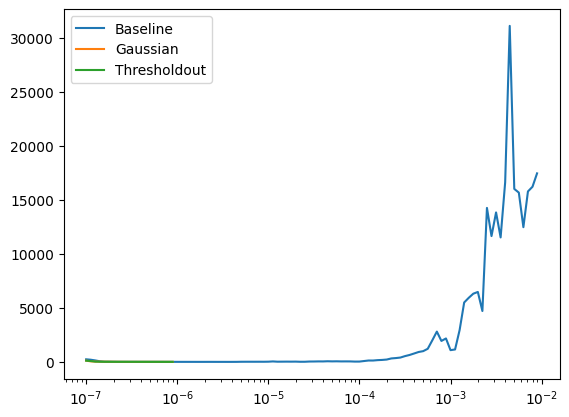

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()

## The mechanized model with check in point and early stop

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

mechanized_model = MechanizedSequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])



## Choose Gaussian mechanism and fit the model

In [22]:

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "mechanized_model_checkpoint", save_best_only=True)
mechanized_model.fit(train_set, epochs = 20,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint])

Epoch 1/20
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 321ms/step - loss: 117.6231 - mae: 118.1231In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      2/Unknown - 1s 180ms/step - loss: 665.1496 - mae: 665.6496In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      3/Unknown - 1s 184ms/step - loss: 6567.8550 - mae: 6568.3550In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 1s 184ms/step - loss: 7286.7554 - mae: 7287.2554In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 1s 181ms/step - loss: 11616.7598 - mae: 11617.2598In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 1s 181ms/step - loss: 13745.4961 - mae: 13745.9961In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      7/Unknown - 1s 176ms/step - loss: 14730.9551 - m

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 563ms/step - loss: 15132.3555 - mae: 15132.8555 - val_loss: 19963.9609 - val_mae: 19964.4648
Epoch 2/20
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/8 [==>...........................] - ETA: 2s - loss: 19916.1406 - mae: 19916.6406In Gaussian Mechanism
Create Gaussian noise when accessing the training data
2/8 [======>.......................] - ETA: 0s - loss: 18830.0625 - mae: 18830.5625In Gaussian Mechanism
Create Gaussian noise when accessing the training data
3/8 [==========>...................] - ETA: 0s - loss: 21438.5684 - mae: 21439.0684In Gaussian Mechanism
Create Gaussian noise when accessing the training data
4/8 [==============>...............] - ETA: 0s - loss: 22403.6328 - mae: 22404.1328In Gaussian Mechanism
Create Gaussian noise when accessing the training data
5/8 [=================>............] - ETA: 0s - loss: 21365.6836 - mae: 21366.1836In Gaussian Mechanism
Create Gaussian noise when acces

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 535ms/step - loss: 21981.0273 - mae: 21981.5254 - val_loss: 16164.0947 - val_mae: 16164.5938
Epoch 3/20
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/8 [==>...........................] - ETA: 1s - loss: 17350.2930 - mae: 17350.7930In Gaussian Mechanism
Create Gaussian noise when accessing the training data
2/8 [======>.......................] - ETA: 0s - loss: 15405.7539 - mae: 15406.2539In Gaussian Mechanism
Create Gaussian noise when accessing the training data
3/8 [==========>...................] - ETA: 0s - loss: 19980.8262 - mae: 19981.3262In Gaussian Mechanism
Create Gaussian noise when accessing the training data
4/8 [==============>...............] - ETA: 0s - loss: 21524.2930 - mae: 21524.7930In Gaussian Mechanism
Create Gaussian noise when accessing the training data
5/8 [=================>............] - ETA: 0s - loss: 20501.8555 - mae: 20502.3555In Gaussian Mechanism
Create Gaussian noise when acces

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 522ms/step - loss: 23592.0410 - mae: 23592.5430 - val_loss: 4512.0586 - val_mae: 4512.5591
Epoch 7/20
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/8 [==>...........................] - ETA: 1s - loss: 6280.1729 - mae: 6280.6729In Gaussian Mechanism
Create Gaussian noise when accessing the training data
2/8 [======>.......................] - ETA: 0s - loss: 4912.0479 - mae: 4912.5479In Gaussian Mechanism
Create Gaussian noise when accessing the training data
3/8 [==========>...................] - ETA: 0s - loss: 15919.3721 - mae: 15919.8721In Gaussian Mechanism
Create Gaussian noise when accessing the training data
4/8 [==============>...............] - ETA: 0s - loss: 20938.4453 - mae: 20938.9453In Gaussian Mechanism
Create Gaussian noise when accessing the training data
5/8 [=================>............] - ETA: 0s - loss: 17890.2227 - mae: 17890.7227In Gaussian Mechanism
Create Gaussian noise when accessing t

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 599ms/step - loss: 20178.4492 - mae: 20178.9492 - val_loss: 1794.5530 - val_mae: 1795.0526
Epoch 8/20
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/8 [==>...........................] - ETA: 1s - loss: 5716.0386 - mae: 5716.5386In Gaussian Mechanism
Create Gaussian noise when accessing the training data
2/8 [======>.......................] - ETA: 1s - loss: 5197.6030 - mae: 5198.1030In Gaussian Mechanism
Create Gaussian noise when accessing the training data
3/8 [==========>...................] - ETA: 0s - loss: 4514.0718 - mae: 4514.5718In Gaussian Mechanism
Create Gaussian noise when accessing the training data
4/8 [==============>...............] - ETA: 0s - loss: 4145.0581 - mae: 4145.5581In Gaussian Mechanism
Create Gaussian noise when accessing the training data
5/8 [=================>............] - ETA: 0s - loss: 10468.8408 - mae: 10469.3408In Gaussian Mechanism
Create Gaussian noise when accessing the t

In [23]:
gaussian_model = keras.models.load_model("mechanized_model_checkpoint",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

## Choose Threshold mechanism and fit the model

In [24]:

mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
mechanized_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "mechanized_model_checkpoint", save_best_only=True)
mechanized_model.fit(train_set, epochs = 20,
          validation_data=valid_set,
          callbacks=[early_stopping, mechanized_model_checkpoint])

Epoch 1/20
In Threshold out Mechanism
387.89453
      1/Unknown - 0s 275ms/step - loss: 22316.0508 - mae: 22389.3301In Threshold out Mechanism
535.5137
      2/Unknown - 0s 196ms/step - loss: 19360.5469 - mae: 19672.6797In Threshold out Mechanism
201.70117
      3/Unknown - 1s 201ms/step - loss: 16804.8945 - mae: 17148.2715In Threshold out Mechanism
252.79492
      4/Unknown - 1s 201ms/step - loss: 20543.3457 - mae: 20755.9160In Threshold out Mechanism
130.72656
      5/Unknown - 1s 199ms/step - loss: 22805.3145 - mae: 22957.8906In Threshold out Mechanism
391.9502
      6/Unknown - 1s 199ms/step - loss: 20209.6504 - mae: 20308.2500In Threshold out Mechanism
405.47498
      7/Unknown - 1s 203ms/step - loss: 17612.8262 - mae: 17674.2031In Threshold out Mechanism
3598.6758
      8/Unknown - 2s 201ms/step - loss: 19386.7871 - mae: 19505.4297

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 599ms/step - loss: 19386.7871 - mae: 19505.4297 - val_loss: 38691.3281 - val_mae: 38691.8281
Epoch 2/20
In Threshold out Mechanism
3099.996
1/8 [==>...........................] - ETA: 1s - loss: 41448.6523 - mae: 41522.3906In Threshold out Mechanism
354.08105
2/8 [======>.......................] - ETA: 1s - loss: 26626.8887 - mae: 26647.2305In Threshold out Mechanism
1027.437
3/8 [==========>...................] - ETA: 0s - loss: 20726.3809 - mae: 20799.9805In Threshold out Mechanism
1331.6211
4/8 [==============>...............] - ETA: 0s - loss: 23772.8750 - mae: 23759.0586In Threshold out Mechanism
1724.8184
5/8 [=================>............] - ETA: 0s - loss: 25873.7109 - mae: 25850.9883In Threshold out Mechanism
66.97803
6/8 [=====================>........] - ETA: 0s - loss: 22196.4043 - mae: 22170.5742In Threshold out Mechanism
515.2346
7/8 [=========================>....] - ETA: 0s - loss: 19147.2012 - mae: 19094.9375In Threshold out M

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 586ms/step - loss: 20188.7949 - mae: 20142.5957 - val_loss: 19738.4863 - val_mae: 19738.9883
Epoch 3/20
In Threshold out Mechanism
2398.164
1/8 [==>...........................] - ETA: 1s - loss: 22572.4395 - mae: 22731.8184In Threshold out Mechanism
76.259766
2/8 [======>.......................] - ETA: 1s - loss: 24038.0508 - mae: 24000.6152In Threshold out Mechanism
478.48242
3/8 [==========>...................] - ETA: 0s - loss: 26142.8555 - mae: 26107.0449In Threshold out Mechanism
685.8789
4/8 [==============>...............] - ETA: 0s - loss: 21051.9707 - mae: 21044.8477In Threshold out Mechanism
439.17273
5/8 [=================>............] - ETA: 0s - loss: 17117.4453 - mae: 17054.7754In Threshold out Mechanism
57.554688
6/8 [=====================>........] - ETA: 0s - loss: 19450.2676 - mae: 19385.9648In Threshold out Mechanism
1316.6973
7/8 [=========================>....] - ETA: 0s - loss: 19731.5742 - mae: 19662.6406In Threshold out

INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


INFO:tensorflow:Assets written to: mechanized_model_checkpoint/assets


8/8 [==============================] - 4s 574ms/step - loss: 19816.2734 - mae: 19786.9590 - val_loss: 2219.2214 - val_mae: 2219.7212
Epoch 5/20
In Threshold out Mechanism
367.98657
1/8 [==>...........................] - ETA: 1s - loss: 3337.4075 - mae: 3268.8447In Threshold out Mechanism
376.6172
2/8 [======>.......................] - ETA: 1s - loss: 20952.9375 - mae: 21097.2949In Threshold out Mechanism
1036.7461
3/8 [==========>...................] - ETA: 0s - loss: 26152.4727 - mae: 26266.1562In Threshold out Mechanism
50.430176
4/8 [==============>...............] - ETA: 0s - loss: 20746.0176 - mae: 20844.0449In Threshold out Mechanism
882.66016
5/8 [=================>............] - ETA: 0s - loss: 18819.7500 - mae: 18967.2148In Threshold out Mechanism
532.78125
6/8 [=====================>........] - ETA: 0s - loss: 19577.1953 - mae: 19653.7344In Threshold out Mechanism
1624.8721
7/8 [=========================>....] - ETA: 0s - loss: 18804.0566 - mae: 18868.5312In Threshold out Me

In [25]:
threshold_model = keras.models.load_model("mechanized_model_checkpoint.h5",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})


In [26]:
threshold_rnn_forecast = threshold_model.predict(series[np.newaxis, :, np.newaxis])
threshold_rnn_forecast = threshold_rnn_forecast[0, split_time - 1:-1, 0]

gaussian_rnn_forecast = model_forecast(
    mechanized_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 64ms/step


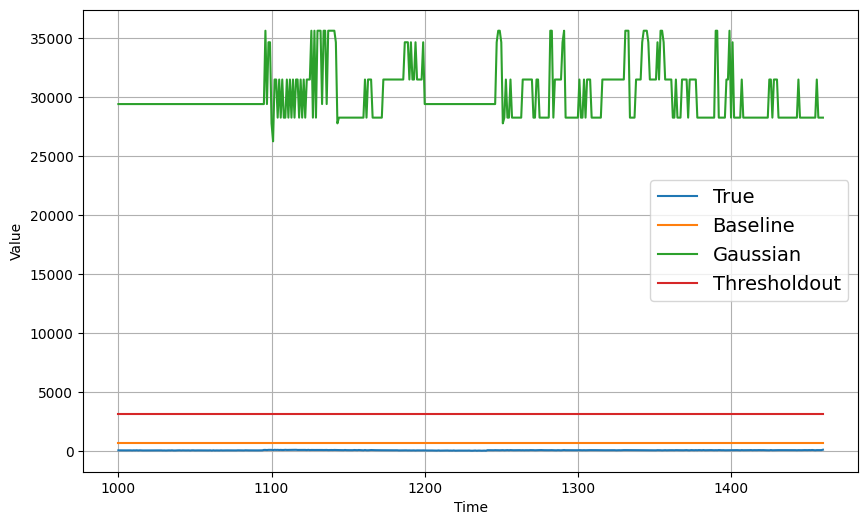

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, empirical_rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")
plot_series(time_valid, threshold_rnn_forecast, label = "Thresholdout")

In [28]:
keras.metrics.mean_absolute_error(x_valid, empirical_rnn_forecast).numpy()

574.4241

In [29]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

29990.14

In [ ]:
keras.metrics.mean_absolute_error(x_valid, threshold_rnn_forecast).numpy()

## Sequence-to-Sequence Forecasting Comparison Evaluation

In [30]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Mechanized Sequence-to-Sequence Forecast 

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

mechanized_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])



## Empirical Model without mechanism

In [44]:

mechanized_model.choose_mech(None)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

empirical_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
8/8 [==============================] - 2s 31ms/step - loss: 12.5482 - mae: 13.0388 - lr: 1.0000e-07
Epoch 2/10
8/8 [==============================] - 0s 27ms/step - loss: 12.4430 - mae: 12.9323 - lr: 1.0798e-07
Epoch 3/10
8/8 [==============================] - 0s 32ms/step - loss: 12.2796 - mae: 12.7687 - lr: 1.1659e-07
Epoch 4/10
8/8 [==============================] - 0s 32ms/step - loss: 12.0967 - mae: 12.5852 - lr: 1.2589e-07
Epoch 5/10
8/8 [==============================] - 0s 30ms/step - loss: 11.8989 - mae: 12.3877 - lr: 1.3594e-07
Epoch 6/10
8/8 [==============================] - 0s 46ms/step - loss: 11.7046 - mae: 12.1920 - lr: 1.4678e-07
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 11.5095 - mae: 11.9960 - lr: 1.5849e-07
Epoch 8/10
8/8 [==============================] - 0s 32ms/step - loss: 11.3061 - mae: 11.7927 - lr: 1.7113e-07
Epoch 9/10
8/8 [==============================] - 0s 26ms/step - loss: 11.1131 - mae: 11.5989 - lr: 1.8478e-07
E

## Choose Gaussian model and fit the mode

In [45]:

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

gaussian_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 396ms/step - loss: 10.8946 - mae: 11.3809In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      2/Unknown - 1s 152ms/step - loss: 11.6117 - mae: 12.0974In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      3/Unknown - 1s 152ms/step - loss: 11.0359 - mae: 11.5209In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 1s 166ms/step - loss: 10.8881 - mae: 11.3724In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 1s 168ms/step - loss: 10.5630 - mae: 11.0467In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 1s 166ms/step - loss: 10.8280 - mae: 11.3121In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      7/Unknown - 1s 168ms/step - loss: 10.7118 - mae: 11.1958In Gaussian Mech

## Choose Threshold model and fit the mode


In [46]:

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)

threshold_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 294ms/step - loss: 9.6700 - mae: 10.1526In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      2/Unknown - 1s 295ms/step - loss: 9.5183 - mae: 10.0005In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      3/Unknown - 1s 255ms/step - loss: 9.6890 - mae: 10.1717In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 1s 241ms/step - loss: 9.8873 - mae: 10.3702In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 1s 221ms/step - loss: 9.9214 - mae: 10.4046In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 1s 206ms/step - loss: 9.9563 - mae: 10.4397In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      7/Unknown - 2s 202ms/step - loss: 9.7419 - mae: 10.2251In Gaussian Mechanism
C

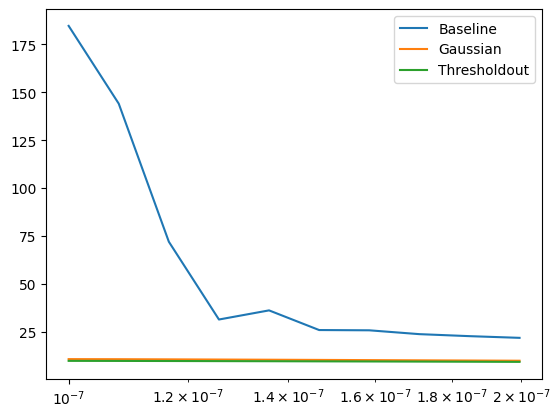

In [47]:
plt.semilogx(history.history["lr"], history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()

## The Sequential model with check in point and early stop

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

mechanized_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

In [49]:

mechanized_model.choose_mech(None)

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
mechanized_model.fit(train_set, epochs = 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 2s 233ms/step - loss: 15682.5312 - mae: 15683.0293 - val_loss: 34339.4219 - val_mae: 34339.9219
Epoch 2/50
8/8 [==============================] - 2s 187ms/step - loss: 20669.8008 - mae: 20670.3027 - val_loss: 37420.9570 - val_mae: 37421.4570
Epoch 3/50
8/8 [==============================] - 2s 218ms/step - loss: 21986.5137 - mae: 21987.0156 - val_loss: 33640.2578 - val_mae: 33640.7617
Epoch 4/50
8/8 [==============================] - 2s 202ms/step - loss: 22034.6602 - mae: 22035.1543 - val_loss: 28650.4727 - val_mae: 28650.9688
Epoch 5/50
8/8 [==============================] - 2s 204ms/step - loss: 21412.0098 - mae: 21412.5137 - val_loss: 25381.8438 - val_mae: 25382.3438
Epoch 6/50
8/8 [==============================] - 2s 240ms/step - loss: 20527.6211 - mae: 20528.1211 - val_loss: 31859.7988 - val_mae: 31860.2988
Epoch 7/50
8/8 [==============================] - 2s 214ms/step - loss: 21200.7695 - mae: 21201.2676 - val_loss: 32269.2148 

In [50]:
empirical_rnn_forecast = model_forecast(mechanized_model, series[..., np.newaxis], window_size)
empirical_rnn_forecast = empirical_rnn_forecast[split_time - window_size:-1, -1, 0]


45/45 [==============================] - 3s 62ms/step


In [51]:

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
mechanized_model.fit(train_set, epochs = 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 252ms/step - loss: 37250.9102 - mae: 37251.4102In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      2/Unknown - 0s 149ms/step - loss: 19760.6211 - mae: 19761.1211In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      3/Unknown - 1s 148ms/step - loss: 13735.3174 - mae: 13735.8184In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 1s 149ms/step - loss: 18449.0762 - mae: 18449.5762In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 1s 152ms/step - loss: 19538.1465 - mae: 19538.6465In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 1s 153ms/step - loss: 20166.7031 - mae: 20167.2031In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      7/Unknown - 1s 154ms/step - loss: 21

In [52]:

gaussian_rnn_forecast = model_forecast(mechanized_model, series[..., np.newaxis], window_size)
gaussian_rnn_forecast = gaussian_rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 3s 65ms/step


In [53]:

mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
mechanized_model.fit(train_set, epochs = 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
In Threshold out Mechanism
975.2113
      1/Unknown - 0s 289ms/step - loss: 21257.3398 - mae: 21265.9668In Threshold out Mechanism
666.92847
      2/Unknown - 0s 197ms/step - loss: 19690.2012 - mae: 19700.2617In Threshold out Mechanism
804.5986
      3/Unknown - 1s 196ms/step - loss: 17916.4102 - mae: 17922.6211In Threshold out Mechanism
777.27576
      4/Unknown - 1s 197ms/step - loss: 20538.9160 - mae: 20546.4844In Threshold out Mechanism
1309.295
      5/Unknown - 1s 227ms/step - loss: 21973.2812 - mae: 21979.8711In Threshold out Mechanism
557.76587
      6/Unknown - 1s 226ms/step - loss: 20440.0645 - mae: 20445.5312In Threshold out Mechanism
693.7108
      7/Unknown - 2s 219ms/step - loss: 18939.8203 - mae: 18945.7129In Threshold out Mechanism
2048.011
8/8 [==============================] - 2s 265ms/step - loss: 19928.0391 - mae: 19903.8301 - val_loss: 31467.3008 - val_mae: 31467.8027
Epoch 2/50
In Threshold out Mechanism
1248.209
1/8 [==>...........................] - E

In [55]:

threshold_rnn_forecast = model_forecast(mechanized_model, series[..., np.newaxis], window_size)
threshold_rnn_forecast = threshold_rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 3s 61ms/step


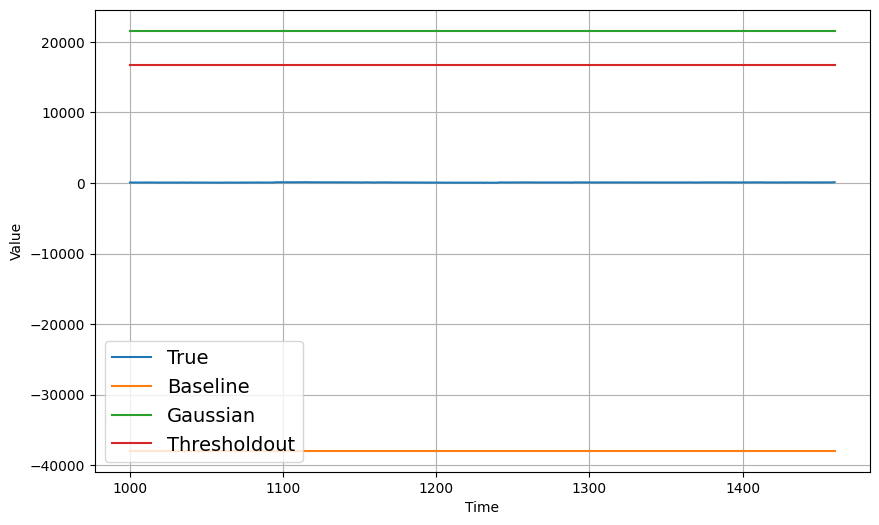

In [56]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, empirical_rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")
plot_series(time_valid, threshold_rnn_forecast, label = "Thresholdout")

In [57]:
keras.metrics.mean_absolute_error(x_valid, empirical_rnn_forecast).numpy()

38040.38

In [58]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

21517.117

In [59]:
keras.metrics.mean_absolute_error(x_valid, threshold_rnn_forecast).numpy()

16593.244